In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

# Критерий Стьюдента в PyMC

In [2]:
sns.set(font_scale=2, style='whitegrid', palette='Set2')

Рассмотрим две независимые выборки

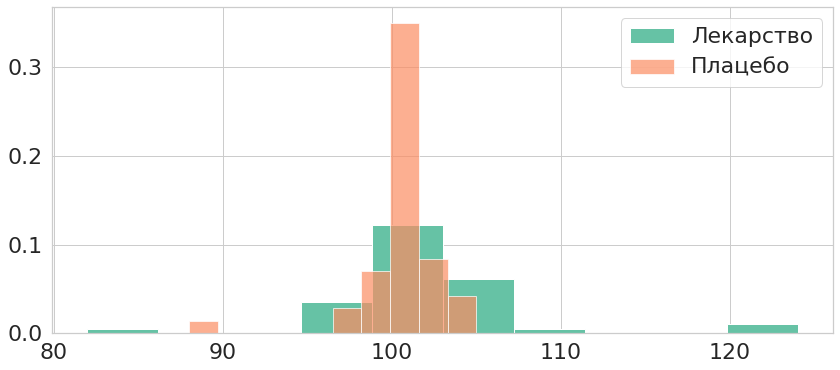

In [3]:
drug = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])
placebo = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])

plt.figure(figsize=(14, 6))
plt.hist(drug, density=True, label='Лекарство')
plt.hist(placebo, density=True, alpha=0.7, label='Плацебо')
plt.legend();

In [4]:
sns.set(font_scale=2, style='darkgrid')

In [5]:
placebo.mean(), placebo.std()

(100.35714285714286, 2.4863573333524784)

Исходный эксперимент: Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.

PyMC-реализация: https://docs.pymc.io/notebooks/BEST.html

Распределения данных:

$X_1, ..., X_n \sim \mathcal{N}(\theta_x, \sigma^2_x)$

$Y_1, ..., Y_m \sim \mathcal{N}(\theta_y, \sigma^2_y)$

Априорные распределения

$\theta_x \sim \mathcal{N}(100, 100)$

$\theta_y \sim \mathcal{N}(100, 100)$

$\sigma_x \sim U(1, 10)$

$\sigma_y \sim U(1, 10)$

Плацебо имеет среднее 100. Наверное, до эксперимента этот факт известен, раз оно плацебо. Поэтому в качестве априорного среднего берем 100.

По данным можно заметить, что возможны небольшие выбросы. Логично заменить нормальное распределение данных на распределение Стьюдента

$X_1, ..., X_n \sim T_\nu(\theta_x, \sigma^2_x)$

$Y_1, ..., Y_m \sim T_\nu(\theta_y, \sigma^2_y)$

На число степеней свободы тоже зададим априорное распределение --- экспоненциальное

$\nu \sim Exp(1/30)$

In [6]:
with pm.Model() as model:
    # априорные распределения средних
    theta_1 = pm.Normal('theta_1', mu=100, sd=10)
    theta_2 = pm.Normal('theta_2', mu=100, sd=10)
    
    # априорные распределения стандартного отклонения
    sigma_1 = pm.Uniform('sigma_1', lower=1, upper=10)
    sigma_2 = pm.Uniform('sigma_2', lower=1, upper=10)
    
    # априорное распределение числа степеней свободы
    nu = pm.Exponential('nu-1', 1/30) + 1
    
    # распределение данных
    group1 = pm.StudentT(
        'drug', nu=nu, mu=theta_1, 
        lam=sigma_1**(-2), observed=drug
    )
    group2 = pm.StudentT(
        'placebo', nu=nu, mu=theta_2, 
        lam=sigma_2**(-2), observed=placebo
    )
    
    # задаем величины, которые хотим отслеживать
    diff_of_means = pm.Deterministic('theta_1-theta_2', 
                                     theta_1 - theta_2)
    diff_of_stds = pm.Deterministic('sigma_1/sigma_2', 
                                    sigma_1 / sigma_2)
    T_stat = pm.Deterministic(
        'T_stat',
        diff_of_means / np.sqrt((sigma_1**2 + sigma_2**2) / 2)
    )
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu-1, sigma_2, sigma_1, theta_2, theta_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1480.49draws/s]


Можно нарисовать граф модели

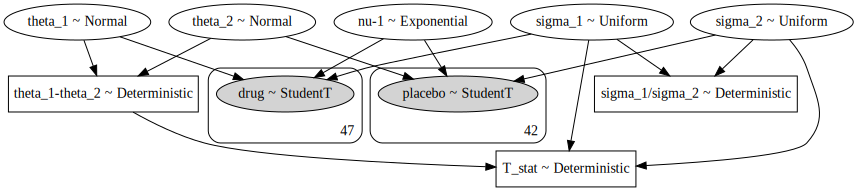

In [7]:
pm.model_to_graphviz(model)

Посмотрим, все ли хорошо на графике траекторий

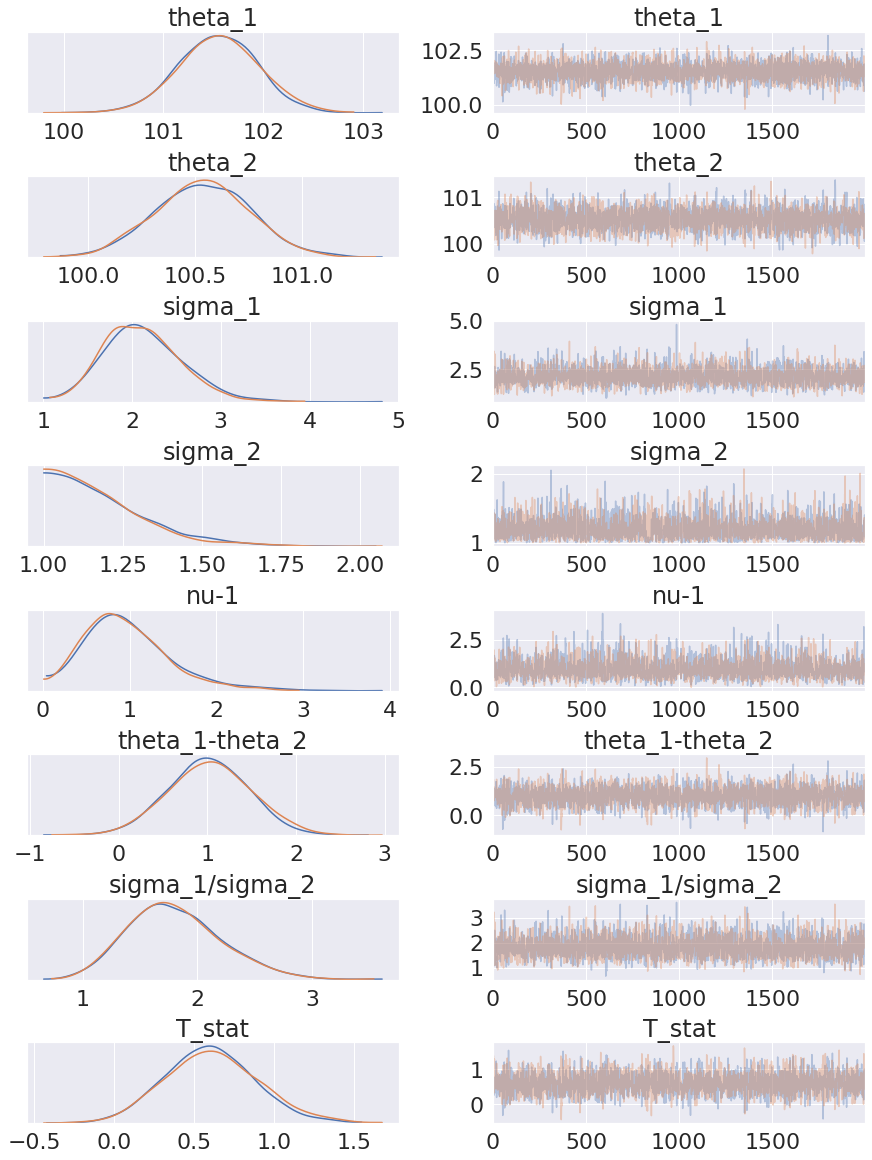

In [8]:
pm.traceplot(trace);

Апостериорные распределения параметров. На графиках показаны также средние, и 95%-й интервал наибольшей плотности

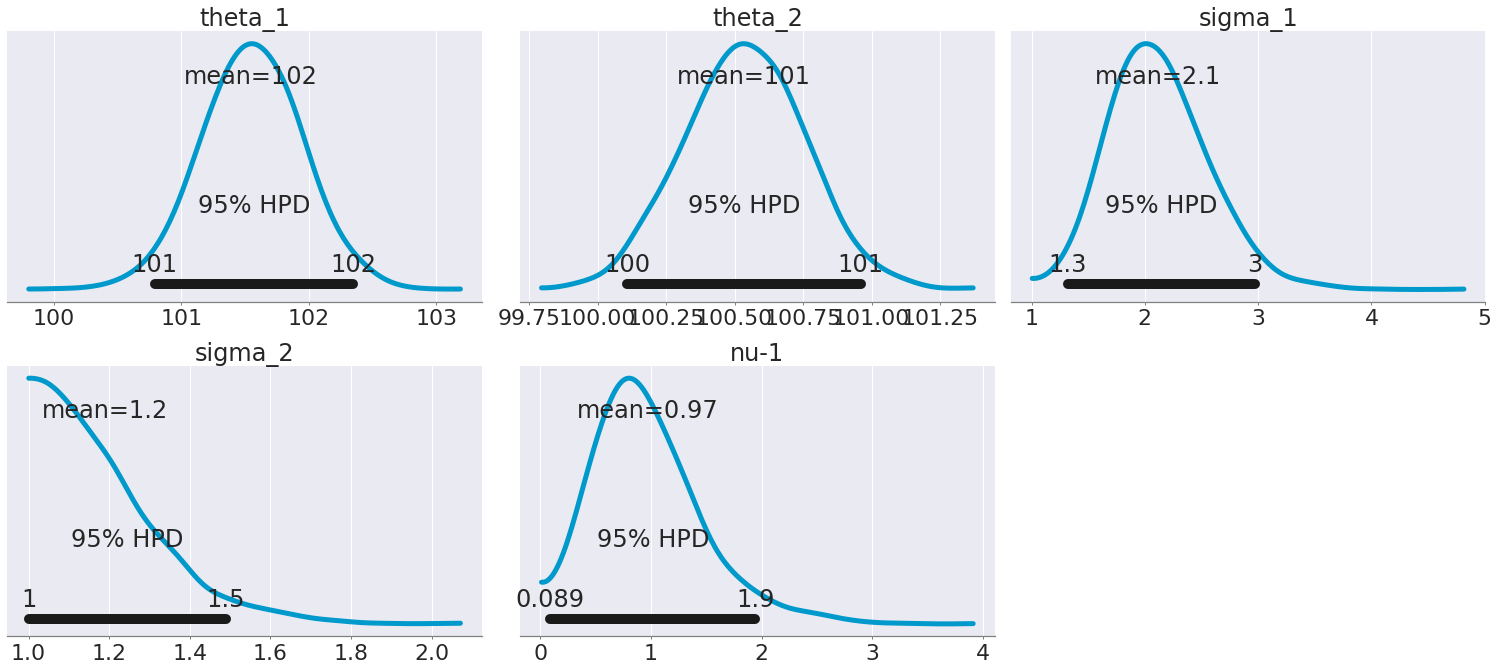

In [10]:
pm.plot_posterior(
    trace, 
    var_names=['theta_1','theta_2', 'sigma_1', 'sigma_2', 'nu-1'],
    credible_interval=0.95,
    linewidth=5,
    color=blue
);

Если хочется проверить гипотезу о равенстве параметра какому-то значению, можно передать это значение в `ref_val`. Ораньжевые числа -- апостериорная вероятность попасть левее и правее этого числа. 

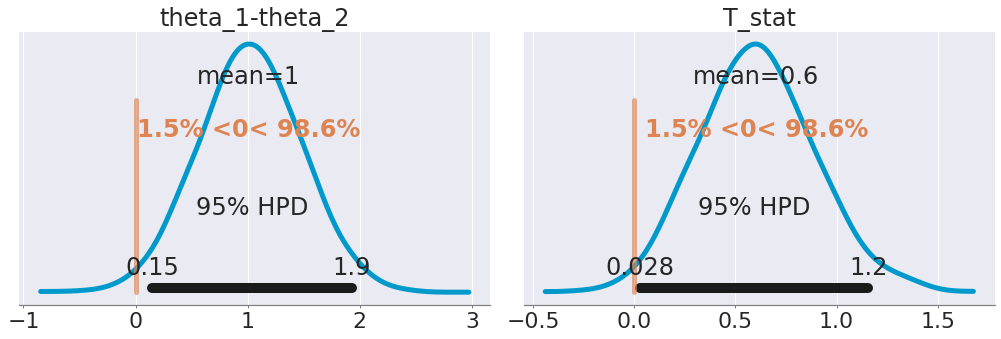

In [11]:
pm.plot_posterior(
    trace, 
    var_names=['theta_1-theta_2', 'T_stat'],
    ref_val=0,
    credible_interval=0.95,
    linewidth=5,
    color=blue);

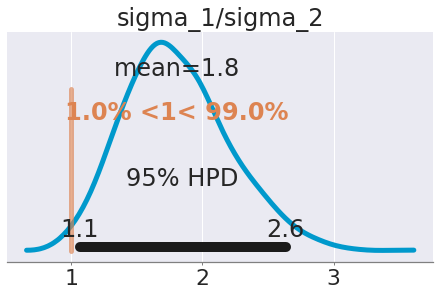

In [12]:
pm.plot_posterior(
    trace, 
    var_names=['sigma_1/sigma_2'],
    ref_val=1,
    credible_interval=0.95,
    linewidth=5,
    color=blue);